In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from setup_problem import load_problem
from tqdm import tqdm

In [2]:
matplotlib.rcParams['figure.figsize'] = [15, 10]
np.random.seed(1337)

# Load and Featurize Dataset

In [3]:
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem('lasso_data.pickle')
x_train_featurized, x_val_featurized = featurize(x_train), featurize(x_val)

# 2. Ridge Regression

## 2.1

In [13]:
from ridge_regression import RidgeRegression as Ridge
from sklearn.metrics import mean_squared_error

Text(0, 0.5, 'Mean Squared Error')

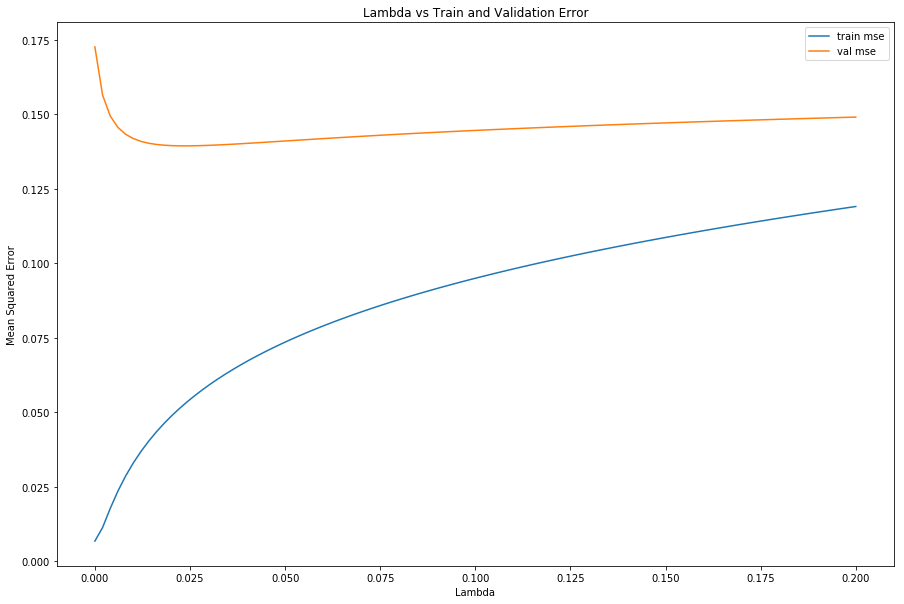

In [16]:
lambdas = np.linspace(0,0.2, 50)
train_error = []
val_error = []
for l in tqdm(lambdas):
    model = Ridge(l)
    model.fit(x_train_featurized, y_train)
    train_error.append(mean_squared_error(y_train, model.predict(x_train_featurized)))
    val_error.append(mean_squared_error(y_val, model.predict(x_val_featurized)))
    
results = pd.DataFrame({
    'lambda': lambdas,
    'train_error': train_error,
    'val_error': val_error
})

plt.plot(lambdas, train_error, label='train mse')
plt.plot(lambdas, val_error, label='val mse')
plt.legend()
plt.title("Lambda vs Train and Validation Error")
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')

Text(0.5, 1.0, 'Comparison of Various Models to Target Function')

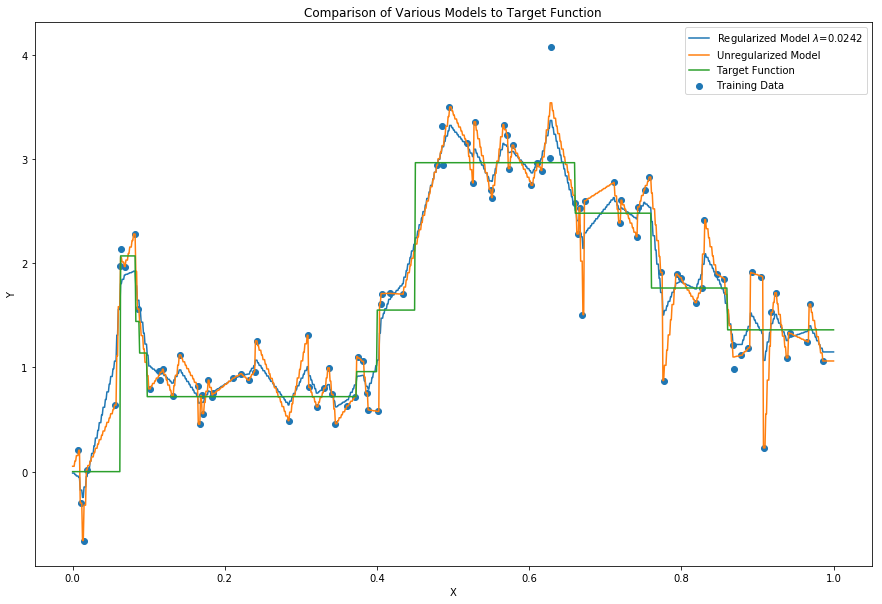

In [19]:
# Get best value for lambda
l = lambdas[np.argmin(val_error)]
best_model = Ridge(l).fit(x_train_featurized, y_train)
unreg_model = Ridge(0).fit(x_train_featurized, y_train)

x = np.linspace(0,1,1000)
x_featurized = featurize(x)

plt.scatter(x_train, y_train, label='Training Data')
plt.plot(x, best_model.predict(x_featurized), label='Regularized Model $\lambda$={}'.format(round(l,4)))
plt.plot(x, unreg_model.predict(x_featurized), label='Unregularized Model')
plt.plot(x, target_fn(x), label='Target Function')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Comparison of Various Models to Target Function")

## 2.2

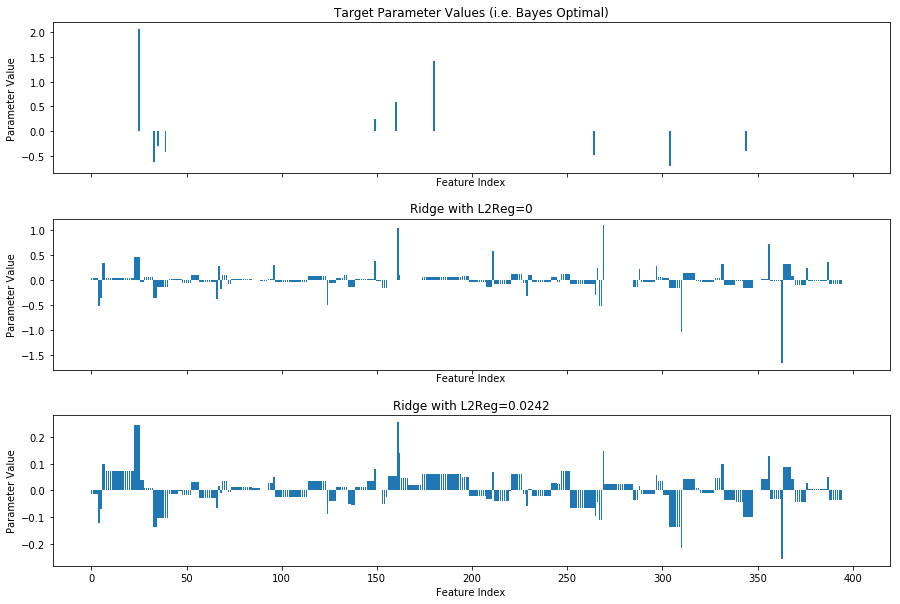

In [23]:
from ridge_regression import compare_parameter_vectors
pred_fns = []
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true})
pred_fns.append({"name":'Ridge with L2Reg=0', "coefs":unreg_model.w_})
pred_fns.append({"name":'Ridge with L2Reg={}'.format(round(l,4)), "coefs":best_model.w_})

fig = compare_parameter_vectors(pred_fns)

With increased regularization we see the scale of the coefficients decrease. It appears that the coefficients with the most weight remain the same, it is only the size of these weights that differ. The graph also shows that the difference in weights between the most important features and other features decreases as regularization is increased.

## 2.3

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
coef_true_binary = (np.abs(coefs_true) > 0).astype(int)

In [56]:
thresholds = [1e-6, 1e-3, 1e-2, 5e-2, 1e-1]
coef_preds = []
for t in thresholds:
    pred = (np.abs(best_model.w_) >= t).astype(int)
    coef_preds.append(pred)

In [57]:
for thresh, pred in zip(thresholds, coef_preds):
    print(confusion_matrix(pred, coef_true_binary))

[[  5   0]
 [385  10]]
[[ 11   0]
 [379  10]]
[[ 53   0]
 [337  10]]
[[277   0]
 [113  10]]
[[365   5]
 [ 25   5]]


# 3. Coordinate Descent for Lasso

## 3.1 Experiments with the Shooting Algorithm

### 3.1.1 
Give an expression for computing
 $a_{j}$ and $c_{j}$ using matrix and vector operations, without
 explicit loops.
 
 
\begin{align}
a_j &= 2X_j^T X_j\\
c_j &= 2(y-Xw + w_j X_j)X_j^T
\end{align}

### 3.1.2
Write a function that computes the Lasso solution for a give $\lambda$ using the shooting algorithm described above. For convergence criteria, continue coordinate descent until a pass through
the coordinates reduces the objective function by less than 10−8
, or you have taken 1000
passes through the coordinates. Compare performance of cyclic coordinate descent to
randomized coordinate descent, where in each round we pass through the coordinates in a
different random order (for your choices of λ). Compare also the solutions attained
(following the convergence criteria above) for starting at 0 versus starting at the ridge
regression solution suggested by Murphy (again, for your choices of λ). If you like, you may
adjust the convergence criteria to try to attain better results (or the same results faster).

In [93]:
def shuffle(X, y):
    tmp = np.hstack((X, y.reshape((len(y),1))))
    np.random.shuffle(tmp)
    return tmp[:,:-1], tmp[:, -1]

def lasso_loss(X, y, w, l):
    # Compute the lasso loss
    return sum(np.square(np.matmul(X, w) - y)) + l*sum(np.abs(w))

def soft(a, b):
    c = np.abs(a) - b
    c_plus = c if c >=0 else 0
    return np.sign(a)*c_plus

In [107]:
def compute_lasso_solution(X, y, l, thresh=1e-8, max_iter=1000, w_init=False, randomized=False):
    """
    Args:
        X: self-explanatory
        y: self-explanatory
        thresh (float): stop optimization if loss reduction is less than this.
        max_iter (int): max iterations through coordinates before stopping optimization.
        init_ridge (bool): if True, initialize weights with Ridge regression solution.
        randomized (bool): if True, shuffle data at epoch end.
        
    Returns:
        w (numpy array): self-explanatory
    """
    
    n_iter = 0
    n_cols = X.shape[1]
    cols = list(range(n_cols))
    
    if w_init == 'ridge':
        w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X) + l*np.eye(n_cols)), X.T), y)
    elif w_init is False:
        w = np.zeros(n_cols)
    else:
        w = w_init
        
    old_loss = lasso_loss(X, y, w, l)
    delta_loss = thresh + 1
    
    
    while n_iter <= max_iter and delta_loss > thresh:  
        if randomized:
            np.random.shuffle(cols)         
        for j in cols:
            X_j = X[:,j]
            if not X_j.any():
                # Edge case if column is all 0
                w[j] = 0
            else:
                a = 2 * np.matmul(X_j.T, X_j)
                c = 2 * np.matmul((y - np.matmul(X, w) + w[j]*X_j).T, X_j)
                w[j] = soft(c/a, l/a)         
        # end of iteration / epoch
        n_iter += 1
        new_loss = lasso_loss(X, y, w, l)
        delta_loss = old_loss - new_loss
        old_loss = new_loss
    return w
            

#### Cyclic vs Randomized Coordinate Descent

In [61]:
%timeit compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-3, randomized=True)

1.78 s ± 385 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%timeit compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-3, randomized=False)

2.97 s ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It appears that randomized coordinate descent converges faster.

#### Effect of solution initialization.

In [98]:
%timeit compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-3, randomized=True, w_init='ridge')

999 ms ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
%timeit compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-3, randomized=True, w_init=False)

1.81 s ± 358 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
w_init = compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-8, randomized=True, w_init='ridge')
w = compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-8, randomized=True, init_ridge=False)

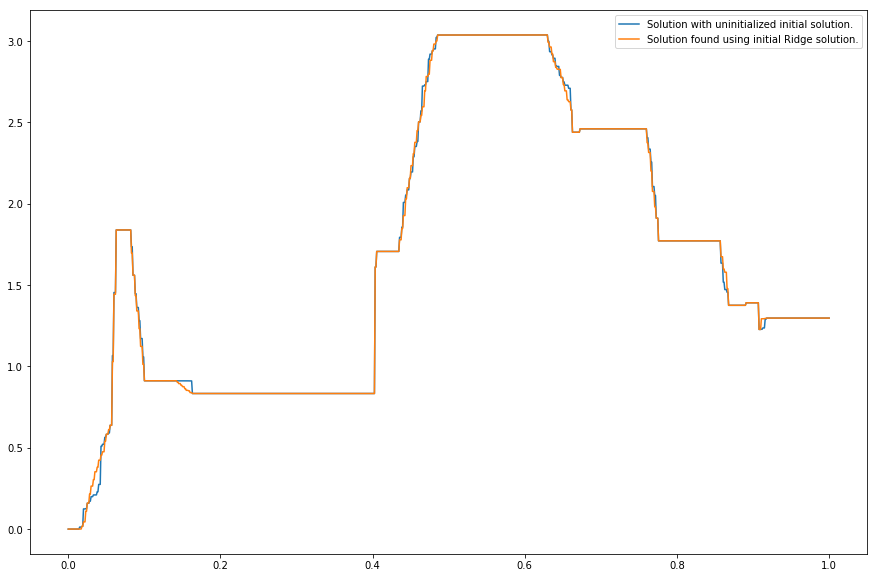

In [70]:
plt.plot(x, np.matmul(x_featurized, w), label='Solution with uninitialized initial solution.')
plt.plot(x, np.matmul(x_featurized, w_init), label='Solution found using initial Ridge solution.')
plt.legend()

Looking at the timings, we can see that initializing the solution with the Ridge solution results in much faster convergence. Also, by plotting the solutions we can see that both methods result in very similar solutions.

### 3.1.3
Run your best Lasso configuration on the training dataset provided, and select the λ that
minimizes the square error on the validation set. Include a table of the parameter values you
tried and the validation performance for each. Also include a plot of these results. Include
also a plot of the prediction functions, just as in the ridge regression section, but this time
add the best performing Lasso prediction function and remove the unregularized least
squares fit. Similarly, add the lasso coefficients to the bar charts of coefficients generated in
the ridge regression setting. Comment on the results, with particular attention to parameter
sparsity and how the ridge and lasso solutions compare. What’s the best model you found,
and what’s its validation performance?

In [74]:
lambdas = [1e-2, 1e-1, 1, 5]
train_losses = []
val_losses = []
best_ridge = best_model
weights = []

for l in lambdas:
    w = compute_lasso_solution(x_train_featurized, y_train, l, thresh=1e-8, randomized=True, w_init='ridge')
    train_preds = np.matmul(x_train_featurized, w)
    val_preds = np.matmul(x_val_featurized, w)
    train_losses.append(mean_squared_error(train_preds, y_train))
    val_losses.append(mean_squared_error(val_preds, y_val))
    weights.append(w)

#### Table of Parameter Search Results

In [83]:
l_search_results = pd.DataFrame({
    'lambda': lambdas,
    'train_mse': train_losses,
    'val_mse': val_losses
})
l_search_results

,lambda,train_mse,val_mse
0,0.01,0.006805,0.170965
1,0.10,0.011139,0.158784
2,1.00,0.091951,0.126315
3,5.00,0.170150,0.157578


In [77]:
best_lasso_w = weights[np.argmin(val_losses)]
l = lambdas[np.argmin(val_losses)]

#### Comparison of Lasso and Ridge to Target Function

Text(0.5, 1.0, 'Comparison of Various Models to Target Function')

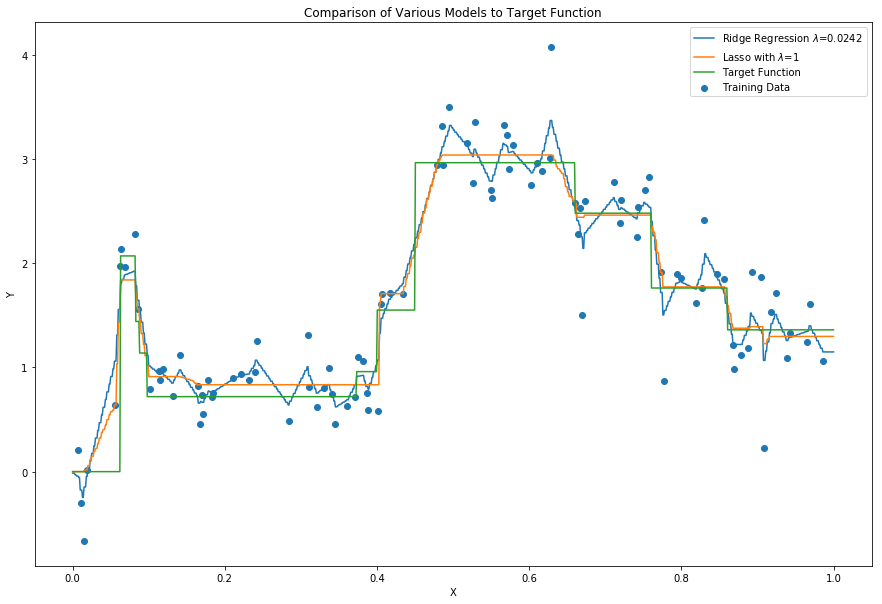

In [81]:
plt.scatter(x_train, y_train, label='Training Data')
plt.plot(x, best_ridge.predict(x_featurized), label='Ridge Regression $\lambda$=0.0242')
plt.plot(x, np.matmul(x_featurized, best_lasso_w), label='Lasso with $\lambda$=1')
plt.plot(x, target_fn(x), label='Target Function')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Comparison of Various Models to Target Function")

#### Coefficient Chart

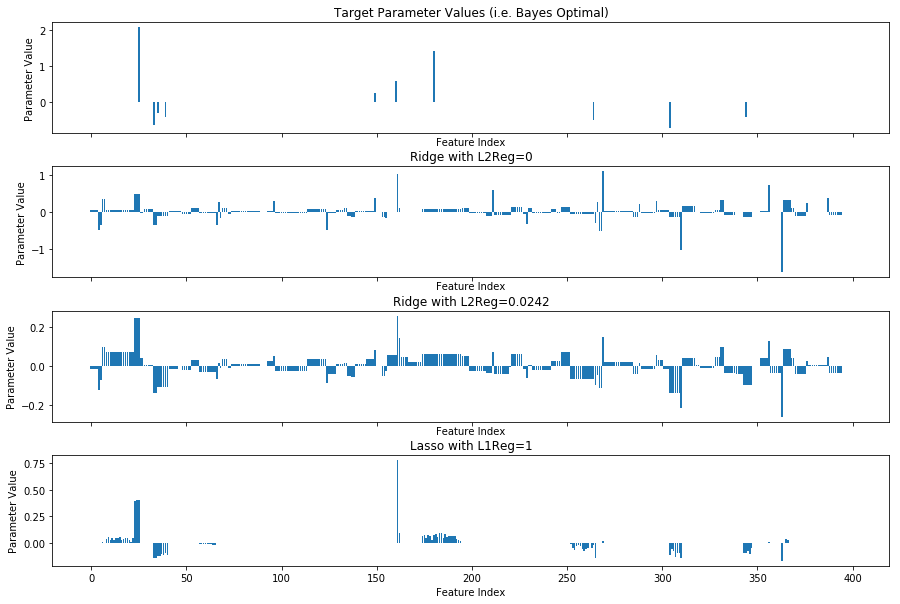

In [84]:
pred_fns = []
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true})
pred_fns.append({"name":'Ridge with L2Reg=0', "coefs":unreg_model.w_})
pred_fns.append({"name":'Ridge with L2Reg={}'.format(0.0242), "coefs":best_model.w_})
pred_fns.append({"name":'Lasso with L1Reg=1', "coefs":best_lasso_w})
fig = compare_parameter_vectors(pred_fns)

#### Comparison of Lasso to Ridge Performance

In [103]:
lasso_losses = min(val_losses)
ridge_loss = mean_squared_error(best_ridge.predict(x_val_featurized), y_val)
print("Lasso model loss: {} \nRidge model loss: {}".format(lasso_losses, ridge_loss))

Lasso model loss: 0.12631526405542964 
Ridge model loss: 0.13938205178504168


Lasso regression resulted in a much sparser solution. In addition, using the lasso loss resulted in improved performance as measured by mean squared error. It outperformed ridge with a mse of 0.126. Also, in this particular case, the lasso solution better exhibits certain characteristics of the Bayes optimal solution such as its sparsity and step function resembelence.

### 3.1.4
Implement the homotopy method described above.
 Plot the results (average validation loss vs λ).

In [306]:
l_max = 2 * np.linalg.norm(np.matmul(x_train_featurized.T, y_train), ord=np.inf)
lambdas = [l_max * 0.8**i for i in range(30)]
val_losses = []

w = 'ridge'
for l in lambdas:
    w = compute_lasso_solution(x_train_featurized, y_train, l, thresh=1e-8, randomized=True, w_init=w)
    val_preds = np.matmul(x_val_featurized, w)
    val_losses.append(mean_squared_error(val_preds, y_val))

/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scala

Text(0.5, 1.0, 'Regularization Path')

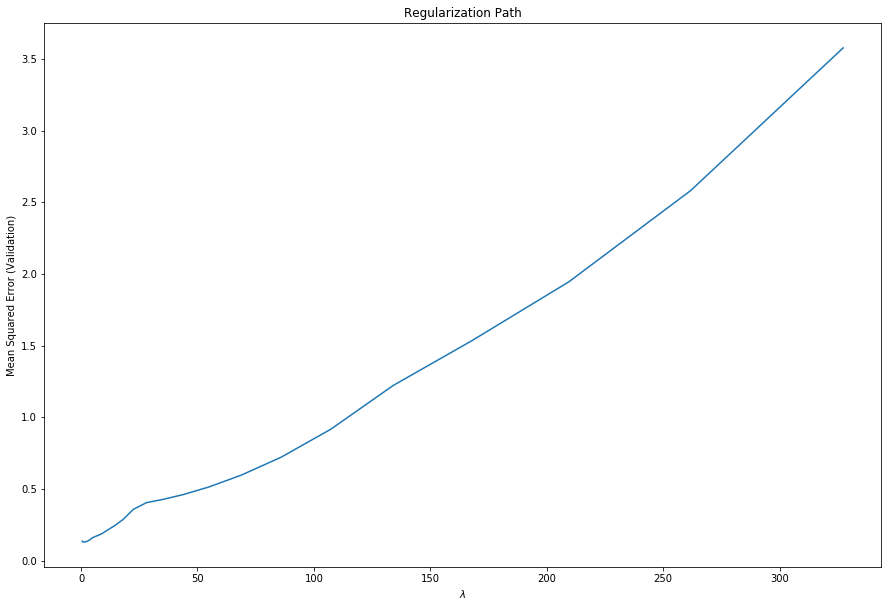

In [307]:
plt.plot(lambdas, val_losses)
plt.xlabel('$\lambda$')
plt.ylabel('Mean Squared Error (Validation)')
plt.title("Regularization Path")

### 3.1.5
Note that the data in Figure 1 is almost entirely nonnegative. Since we don’t have
an unregularized bias term, we have “pay for” this offset using our penalized parameters. Note
also that λmax would decrease significantly if the y values were 0 centered (using the training
data, of course), or if we included an unregularized bias term. Experiment with one or both
of these approaches, for both and lasso and ridge regression, and report your findings

We will try centering the y values

In [126]:
y_mean = y_train.mean()
y_train_trans = y_train - y_mean
y_val_trans = y_val - y_mean

l_max_trans = 2 * np.linalg.norm(np.matmul(x_train_featurized.T, y_train_trans), ord=np.inf)
print("With 0 centered y values, l_max = {}".format(l_max_trans))

With 0 centered y values, l_max = 66.51995371985255


In [150]:
lambdas_trans = [l_max_trans * 0.8**i for i in range(30)]
val_losses_centered = []

w = 'ridge'
for l in lambdas_trans:
    w = compute_lasso_solution(x_train_featurized, y_train_trans, l, thresh=1e-8, randomized=True, w_init=w)
    val_preds = np.matmul(x_val_featurized, w)
    val_losses_centered.append(mean_squared_error(val_preds, y_val_trans))

/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cfizette/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scala

Text(0.5, 1.0, 'Regularization Path (Centered Y Values)')

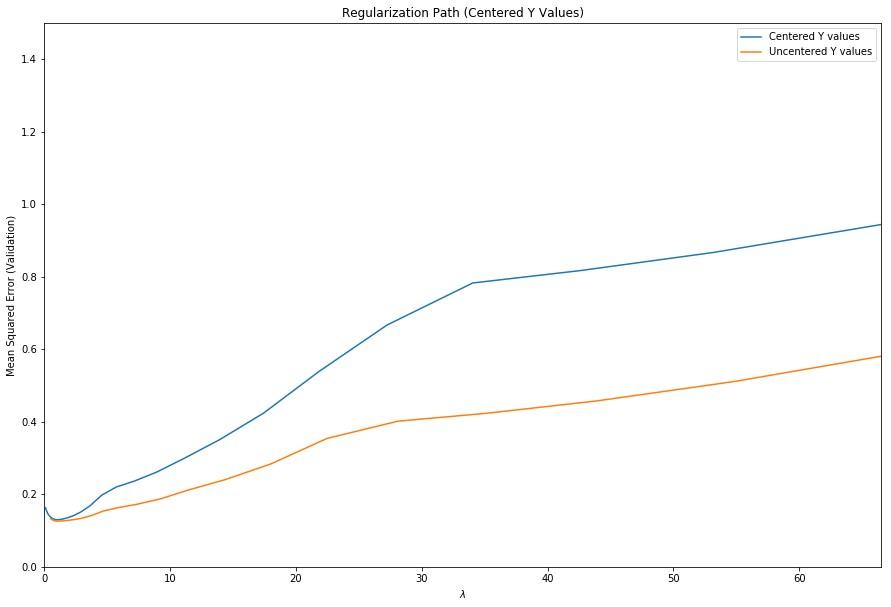

In [160]:
plt.plot(lambdas_trans, val_losses_centered, label='Centered Y values')
plt.plot(lambdas, val_losses, label='Uncentered Y values')
plt.xlim(0, max(lambdas_trans))
plt.ylim(0,1.5)
plt.xlabel('$\lambda$')
plt.legend()
plt.ylabel('Mean Squared Error (Validation)')
plt.title("Regularization Path (Centered Y Values)")

In [142]:
best_ridge.fit(x_train_featurized, y_train_trans)
w_lasso = compute_lasso_solution(x_train_featurized, y_train_trans, 1, thresh=1e-8, randomized=True, w_init='ridge')

ValueError: x and y must have same first dimension, but have shapes (400,) and (1000,)

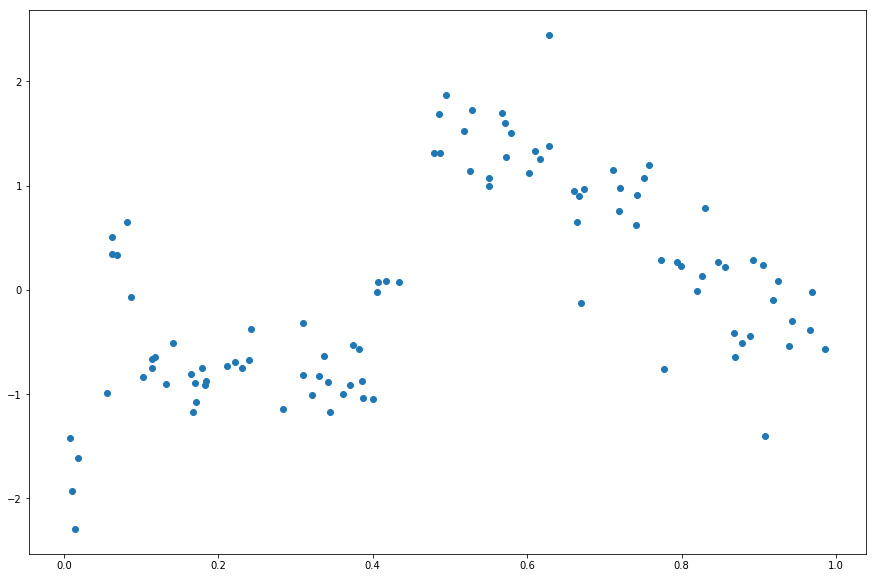

In [201]:
plt.scatter(x_train, y_train_trans, label='Training Data')
plt.plot(x, best_ridge.predict(x_featurized), label='Ridge Regression $\lambda$=0.0242')
plt.plot(x, np.matmul(x_featurized, w_lasso), label='Lasso with $\lambda$=1')
plt.plot(x, target_fn(x) - y_mean, label='Target Function')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Comparison of Various Models to Target Function (Centered Y Values)")

Using centered y values did decrease lambda_max from around 330 to 66. The best solutions do not appear to differ much from the best solution using uncentered y values. However, looking at the regularization path for lasso regression, we see that using the centered y values results in higher mean squared error outside of the optimal lambda values.

# 4 Lasso Properties

## 4.1 Deriving $\lambda_{max}$

### 4.1.1
Compute $J'(0;v)$. That is, compute the one-sided directional derivative
 of $J(w)$ at $w=0$ in the direction $v$. [Hint: the result should
 be in terms of $X,y,\lambda,\text{ and }v$.]

\begin{align}
J'(0:v) &= \lim_{h\downarrow 0} \frac{J(hv) - J(0)}{h}\\
&= \lim_{h\downarrow0} \frac{\|hXv-y\|_2^2 + \lambda h - \|-y\|_2^2}{h}\\
&= \lim_{h\downarrow0} \frac{h^2 \|Xv\|_2^2 -2h(Xv)^T y + \lambda h}{h}\\
&= \lim_{h\downarrow0} h \|Xv\|_2^2 -2(Xv)^T y + \lambda\\
&= \lambda -2(Xv)^T y
\end{align}

### 4.1.2
Show that for any $v\neq0$, we have $J'(0;v)\ge0$
 if and only if $\lambda\ge C$, for some $C$ that depends on $X,y,\text{ and }v$.

\begin{align}
J'(0:v) &\geq 0\\
\lambda -2(Xv)^T y &\geq 0\\
\lambda &\geq -2(Xv)^T y
\end{align}

Thus
\begin{align}
C = -2(Xv)^T y
\end{align}

## 4.2 Feature Correlation

# 6. Projected SGD via Variable Splitting

## 6.1
Implement projected SGD to solve the above optimization problem for the same
λ’s as used with the shooting algorithm. Since the two optimization algorithms should find
essentially the same solutions, you can check the algorithms against each other. Report the
differences in validation loss for each λ between the two optimization methods. (You can
make a table or plot the differences.)

In [286]:
def compute_projected_lasso(X, y, l, alpha=0.1, n_epochs=1000, w_init='ridge'):
    # alpha: step size
    n_cols = X.shape[1]
    
    if w_init == 'ridge':
        w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X) + l*np.eye(n_cols)), X.T), y)
    else:
        w = np.zeros(n_cols)

    w_pos = w
    w_neg = -w
    w_pos[w_pos<0] = 0
    w_neg[w_neg<0] = 0
    #w_pos = np.clip(w, a_min=0)
    #w_neg = -np.clip(w, a_max=0)
        
    #old_loss = lasso_loss(X, y, w, l)
    #delta_loss = thresh + 1
        
    
    for epoch in range(n_epochs):            
        for i, x in enumerate(X):
            residual = np.dot(x, w) - y[i]
            grad_w_pos = 2 * x * residual + l
            grad_w_neg = -2 * x * residual + l
            
            w_pos = w_pos - alpha*grad_w_pos
            w_neg = w_neg - alpha*grad_w_neg
            
            # Project back into valid set
            w_pos[w_pos<0] = 0
            w_neg[w_neg<0] = 0
            #w_pos = np.clip(w_pos, a_min=0)
            #w_neg = np.clip(w_neg, a_max=0)
            
            w = w_pos - w_neg
            
    return w
    

In [303]:
w = compute_projected_lasso(x_train_featurized, y_train, 0.015, alpha=0.001, w_init='ridge', n_epochs=2000)

(-1, 4)

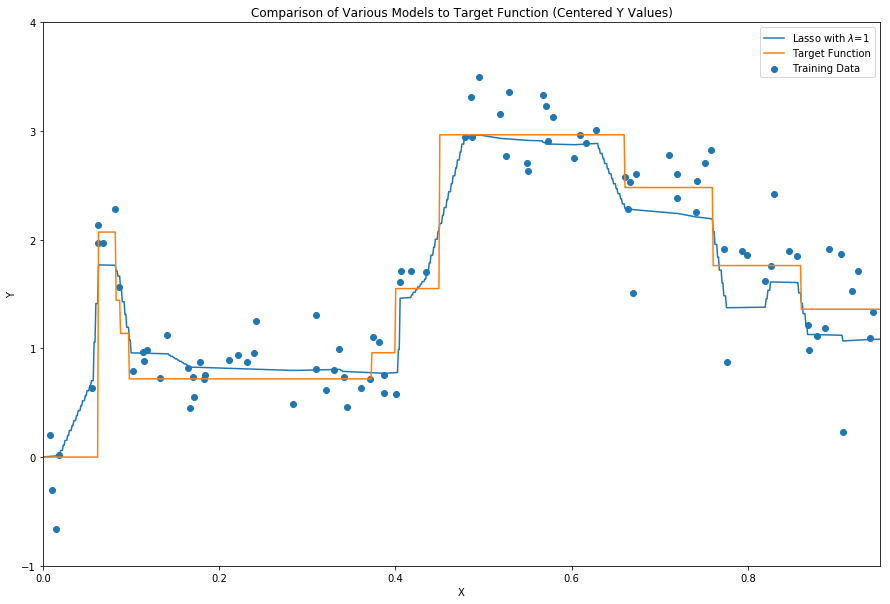

In [304]:
plt.scatter(x_train, y_train, label='Training Data')
#plt.plot(x, best_ridge.predict(x_featurized), label='Ridge Regression $\lambda$=0.0242')
plt.plot(x, np.matmul(x_featurized, w), label='Lasso with $\lambda$=1')
plt.plot(x, target_fn(x), label='Target Function')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Comparison of Various Models to Target Function (Centered Y Values)")
plt.xlim(0,0.95)
plt.ylim(-1,4)

In [262]:
w

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na